In [ ]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
import seaborn as sb
import deepdish as dd
import seaborn as sns

seed = 42
np.random.seed(seed=seed)


data_setting = 'rawflt'
nb_classes = 2
splitting = 'custom'
if data_setting.startswith('raw'):
    model_setting = 'dl4tsc_inc'#'dl4tsc_inc'#'conv1d'
else:
    model_setting = 'DenseNet121'

### data collecting

In [2]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    13610
0     8244
dtype: int64

val: 
1    4568
0    2717
dtype: int64

test: 
1    12337
0     3139
dtype: int64


## Loading model

In [3]:
TL = False

if TL:
    data = Dataset('Wingbeats')
    dataset = data
    splitting='random'
    modelname = f'{TEMP_DATADIR}/Flies_TL_{data_setting}_{model_setting}_{splitting}.h5'

    flag = ''
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
    using_conv2d = False
    base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
    base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # no need to load mosquito weights, we load directly transfer-learned weights after this "if" statement

    if data_setting == 'rawflt':
        if model_setting=='dl4tsc_inc':
            base_output = base_model.layers[-2].output
            new_output = Dense(nb_classes, activation="softmax")(base_output)
            model = Model(inputs=base_model.inputs, outputs=new_output)
        else:
            model = Sequential()
            for layer in base_model.layers[:-1]: # go through until last layer
                model.add(layer)
            #     print(layer.trainable)
            model.add(Dense(nb_classes, activation='softmax'))
    elif data_setting == 'stftflt':
        base_output = base_model.layers[-2].output
        new_output = Dense(nb_classes, activation="softmax")(base_output)
        model = Model(inputs=base_model.inputs, outputs=new_output)
else:
    
    splitting = 'custom'
    modelname = f'{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5'
    
    traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes).config
print(f"Model name: {modelname}")
model.load_weights(modelname)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model name: /home/kalfasyan/projects/wingbeat_frequencies/temp_data//Flies_rawflt_dl4tsc_inc_custom.h5


In [4]:
# model.summary()

In [5]:
pred = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [6]:
model.layers[-5:]

0.83


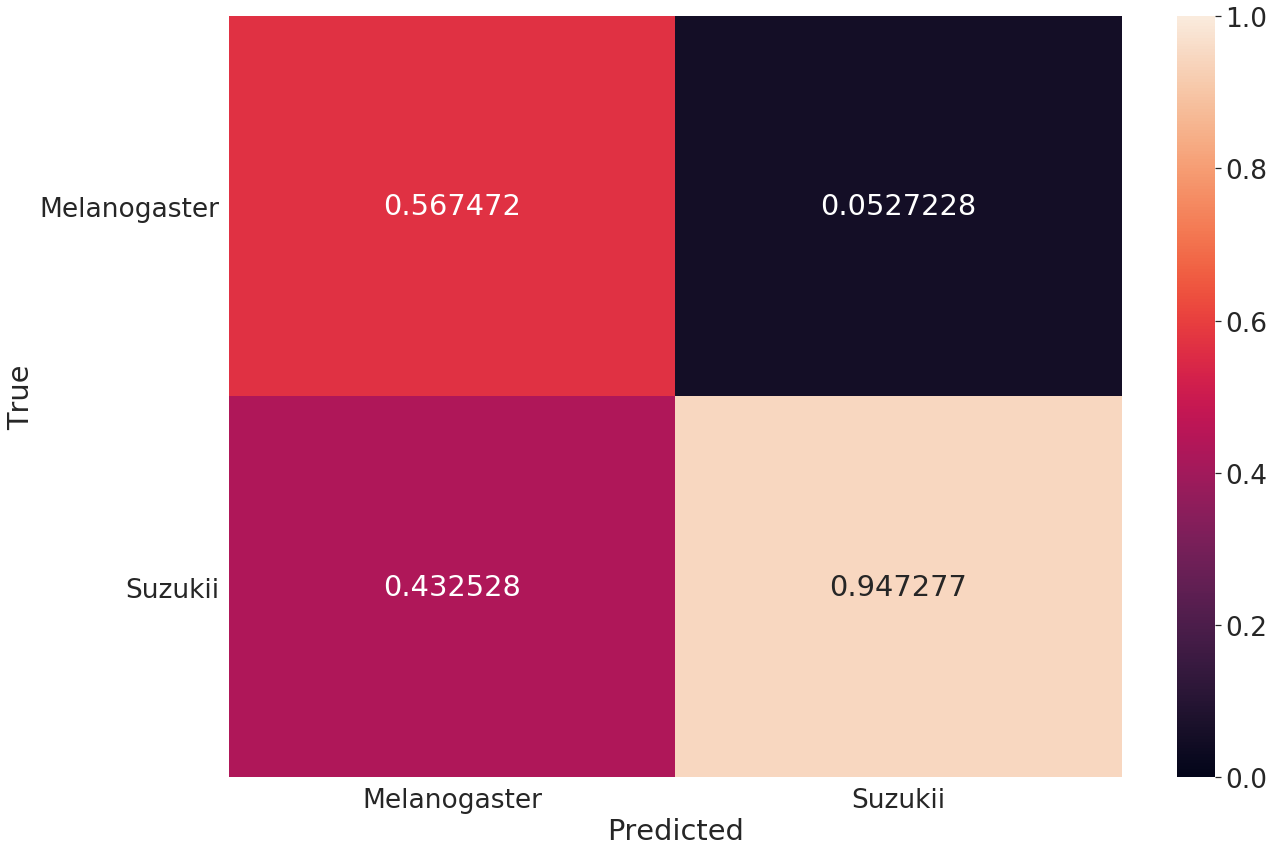

In [53]:
y_pred=np.argmax(pred, axis=1)

mapping = {0:'Melanogaster', 1: 'Suzukii', 2: 'Zaprionus'}

k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

mapping_ar = np.zeros(k.max()+1,dtype=v.dtype) #k,v from approach #1
mapping_ar[k] = v
y_test_mapped = mapping_ar[y_test]
y_pred_mapped = mapping_ar[y_pred]
ba = balanced_accuracy_score(y_true=y_test_mapped, y_pred=y_pred_mapped)
print(f"{ba:.2f}")
cm = confusion_matrix(y_true=y_test_mapped, y_pred=y_pred_mapped,normalize='pred')

sns.set(font_scale=2.4)
plt.figure(figsize=(20,14))
lbls = np.unique(y_test_mapped)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=1)
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizePred.png', format='png', bbox_inches='tight')

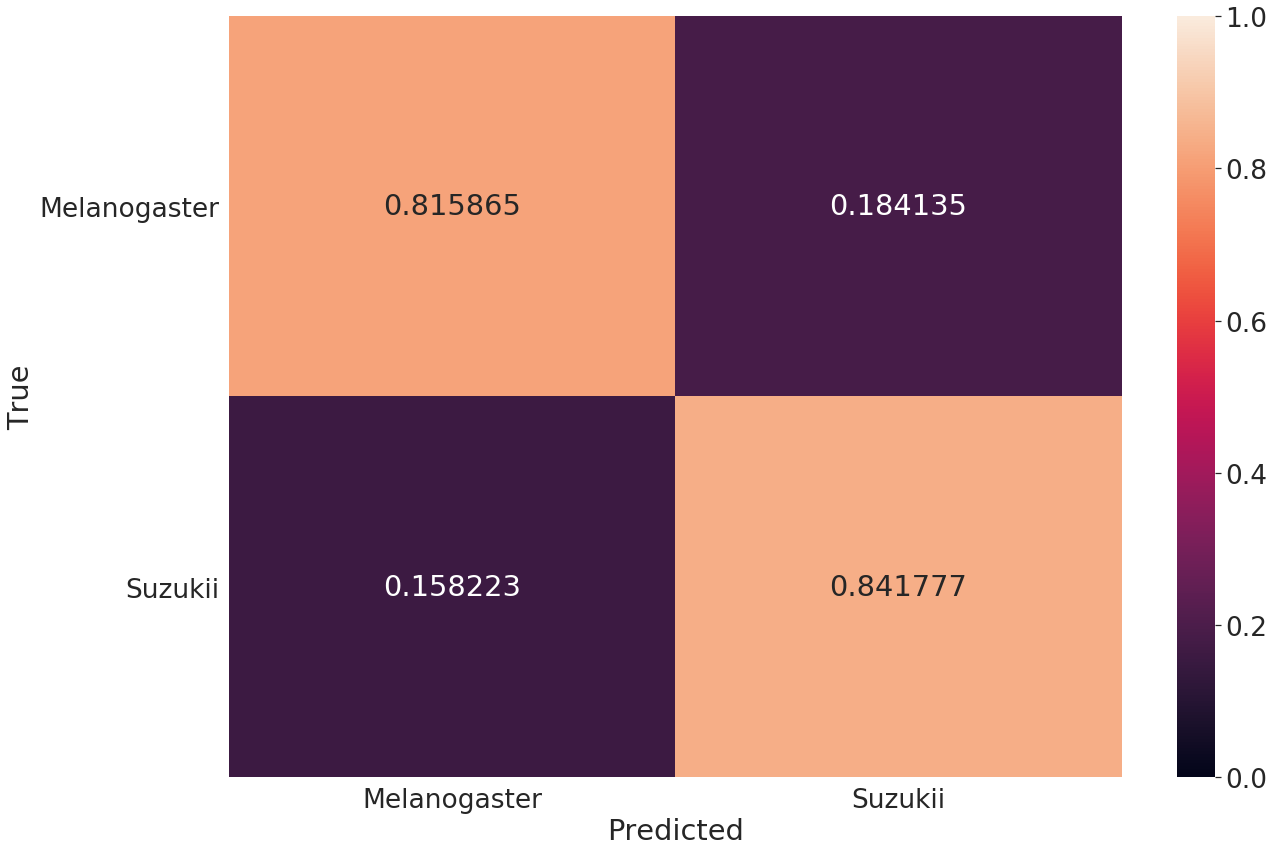

In [54]:
cm = confusion_matrix(y_true=y_test_mapped, y_pred=y_pred_mapped,normalize='true')
plt.figure(figsize=(20,14))
lbls = np.unique(y_test_mapped)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=1)
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizeTrue.png', format='png', bbox_inches='tight')

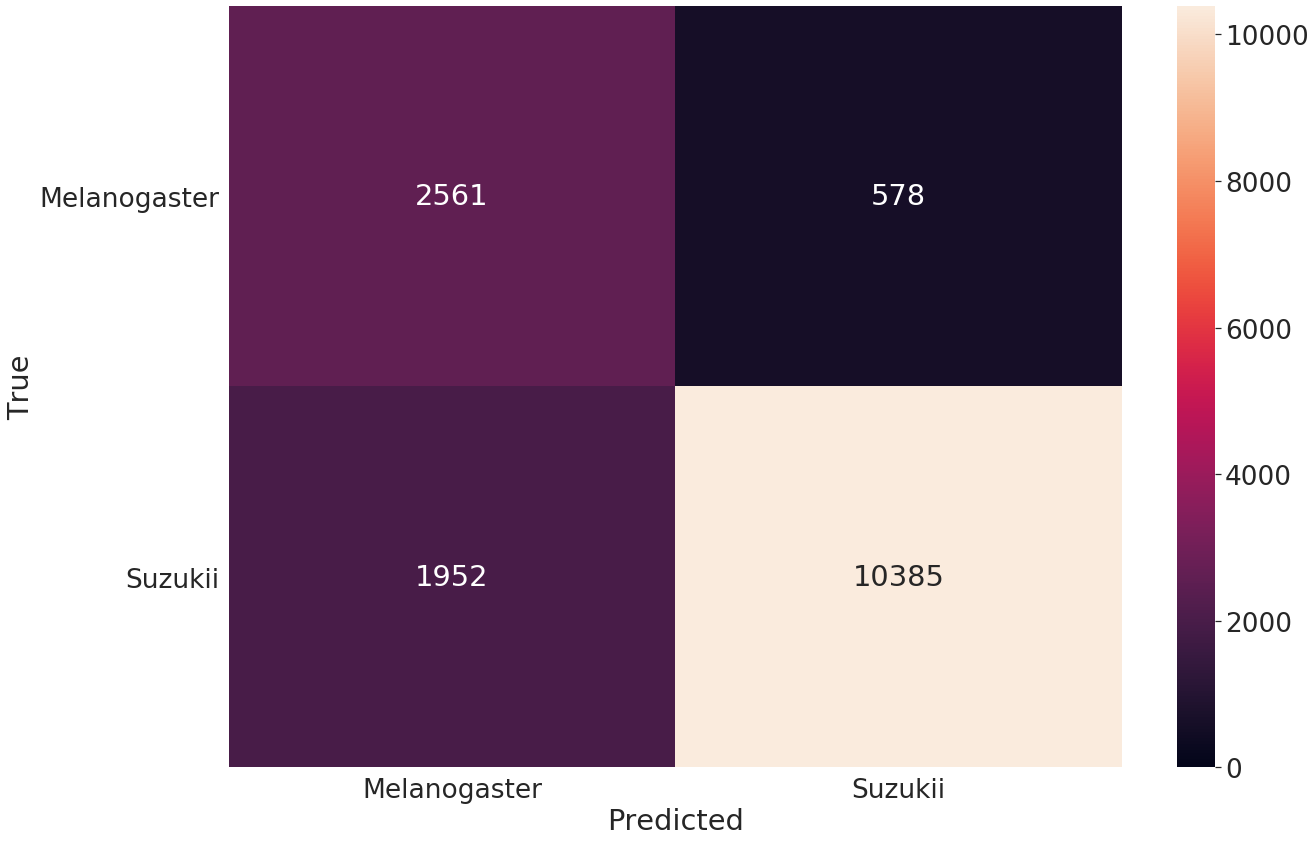

In [56]:
cm = confusion_matrix(y_true=y_test_mapped, y_pred=y_pred_mapped)#,normalize='true')

plt.figure(figsize=(20,14))
lbls = np.unique(y_test_mapped)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=np.max(cm))
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizeNone.png', format='png', bbox_inches='tight')

# ROC curve

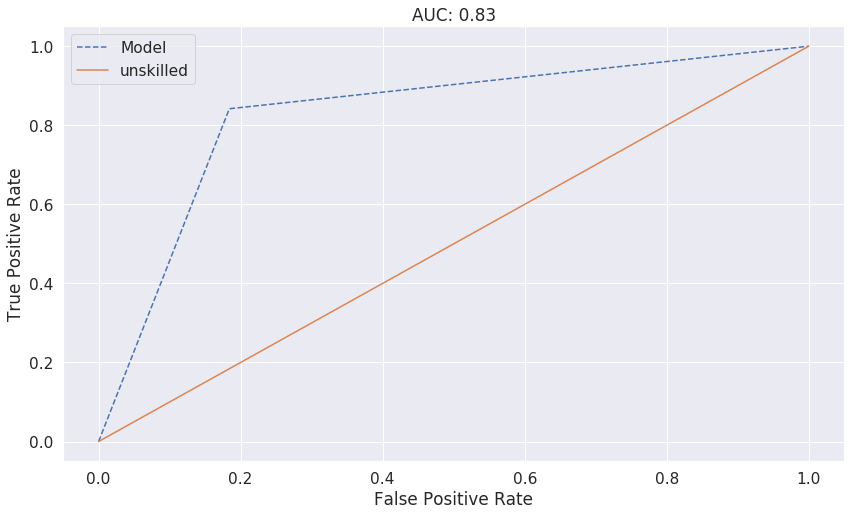

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ns_probs = [0 for _ in range(len(y_test))]
fpr_ns, tpr_ns, th_ns = roc_curve(y_test, ns_probs) 

plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, linestyle='--', label='Model')
plt.plot(fpr_ns, tpr_ns, linestyle='-', label='unskilled')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_auc{roc_auc_score(y_test, y_pred):.2f}.png', format='png', bbox_inches='tight')

# Precision-Recall curve

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

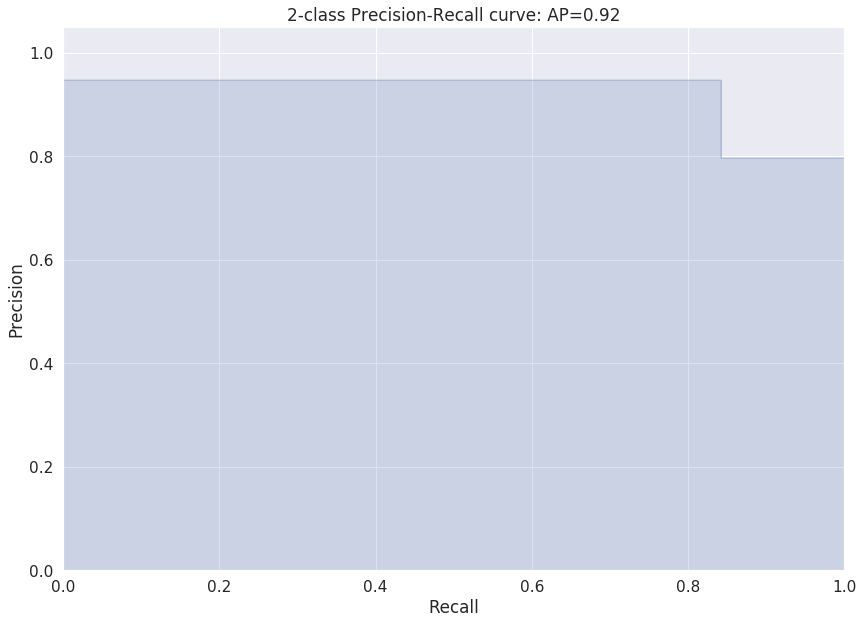

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure(figsize=(14,10))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# T-sne and UMAP visualizations

In [30]:
lg = DatasetConfiguration(names=['LG'])
lg.select(name='LG', species=['LG_zapr_26_09'])
lg.read()
lg.clean()
lg.df.labels = lg.df.labels.apply(lambda x: x.replace("LG_zapr_26_09", '0'))
lg.df.labels.value_counts()

Dataset - LG - exists: True


0    7160
Name: labels, dtype: int64

In [41]:
base_model = model
base_output = base_model.layers[-3].output
model_avgpool = Model(inputs=base_model.inputs, outputs=base_output)

In [42]:
preddph = model_avgpool.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [43]:
predzap = model_avgpool.predict(valid_generator(lg.df.fnames.tolist(), lg.df.labels.tolist(),
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [44]:
# sub = pd.DataFrame(np.round(predzap,decimals=2))
# sub.boxplot(showfliers=False)
# print(f"Zaprionus samples with prediction probability between 20% and 80%: {sub[sub[0].apply(lambda x: 0.35<x<0.65)].shape[0]}")
# print(f"Total Zaprionus samples: {sub.shape[0]}")

In [45]:
# np.vstack((pred,pred2)).shape
# dph = pd.DataFrame({"pred1": preddph[:,0], "pred2": preddph[:,1], "y": y_test})
# zap = pd.DataFrame({"pred1": predzap[:,0], "pred2": predzap[:,1], "y": 2})

In [46]:
twos = [2 for i in range(predzap.shape[0])]

features = np.vstack((preddph,predzap))
targets = np.hstack((np.array(y_test), np.array(twos)))

df = pd.DataFrame(features)
df['y'] = targets
# df = df.sample(4050)

# T-sne

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30948 samples in 0.401s...
[t-SNE] Computed neighbors for 30948 samples in 14.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30948
[t-SNE] Computed conditional probabilities for sample 2000 / 30948
[t-SNE] Computed conditional probabilities for sample 3000 / 30948
[t-SNE] Computed conditional probabilities for sample 4000 / 30948
[t-SNE] Computed conditional probabilities for sample 5000 / 30948
[t-SNE] Computed conditional probabilities for sample 6000 / 30948
[t-SNE] Computed conditional probabilities for sample 7000 / 30948
[t-SNE] Computed conditional probabilities for sample 8000 / 30948
[t-SNE] Computed conditional probabilities for sample 9000 / 30948
[t-SNE] Computed conditional probabilities for sample 10000 / 30948
[t-SNE] Computed conditional probabilities for sample 11000 / 30948
[t-SNE] Computed conditional probabilities for sample 12000 / 30948
[t-SNE] Computed conditional probabilities for s

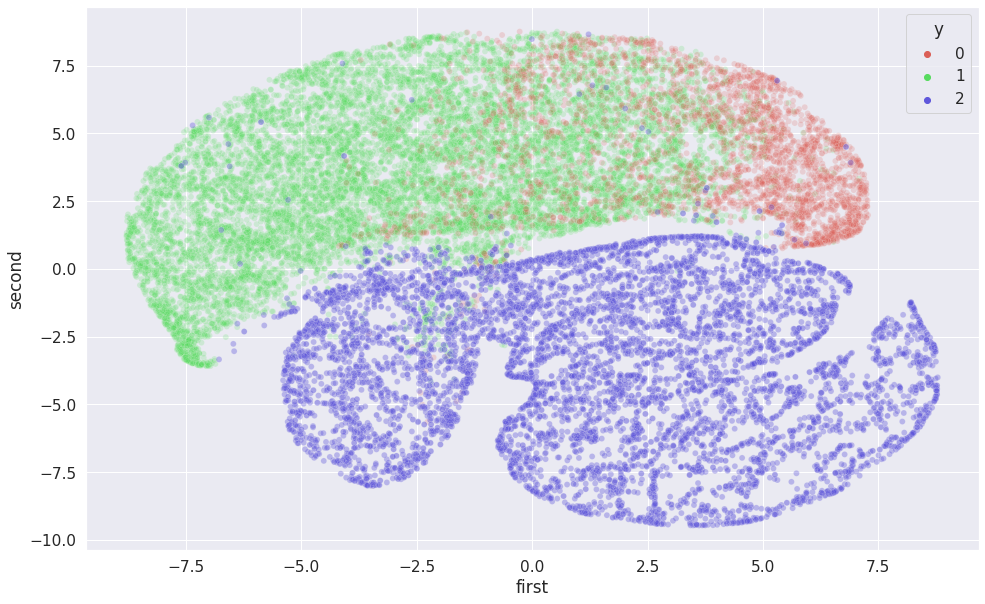

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.iloc[:,:-1].values)

df_tsne = pd.DataFrame(tsne_results)
df_tsne['y'] = df.y
df_tsne.columns = ['first','second','y']

plt.figure(figsize=(16,10))
sns.scatterplot( x='first', 
                y='second',
                hue='y',
                palette=sns.color_palette("hls", 3),
                data=df_tsne,
                legend="full",
                alpha=0.2)
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_TSNE.png', format='png', bbox_inches='tight')

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


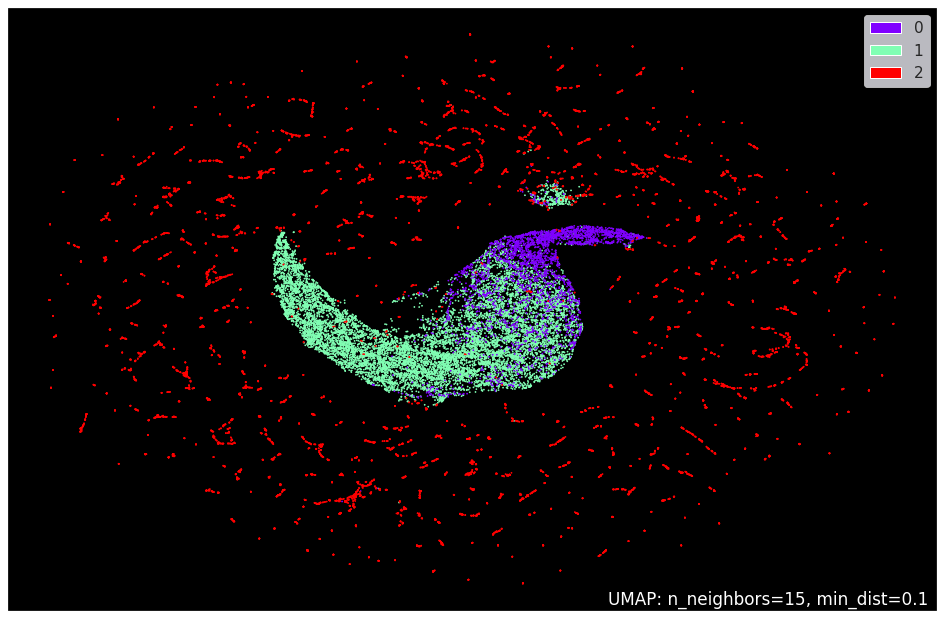

In [48]:
import umap
import umap.plot
sns.set(font_scale=1.4)

mapper = umap.UMAP(random_state=seed).fit(df.iloc[:,:-1].values)

umap.plot.points(mapper, labels=df.y.values, width=1200, height=800, background='white', theme='fire')
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_UMAP.png', format='png', bbox_inches='tight')

# mapper.embedding_

In [49]:
import sklearn.neighbors

outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.005).fit_predict(df.iloc[:,:-1].values)

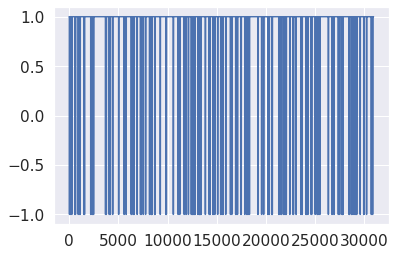

In [50]:
plt.plot(outlier_scores)
# mapper.embedding_.shape

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x = mapper.embedding_ 
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(x,df.y.values)
score = cross_val_score(lr, x, df.y.values, cv=5)
print("UMAP embeddings: \nCross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))
print()
x = df_tsne.iloc[:,:-1].values #
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(x,df.y.values)
score = cross_val_score(lr, x, df.y.values, cv=5)
print("T-sne embeddings: \nCross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))

UMAP embeddings: 
Cross_val_score: [0.34442649 0.34798061 0.34410339 0.34238164 0.3427048 ],
mean: 		0.3443193888996346

T-sne embeddings: 
Cross_val_score: [0.89337641 0.90129241 0.91066236 0.90596219 0.8820488 ],
mean: 		0.8986684333113807


## Misclassification per dataset

In [52]:
big = pd.DataFrame(X_test, columns=['fnames'])
big['dataset'] = pd.Series(X_test).apply(lambda x: x.split('/')[5])
big['species'] = pd.Series(X_test).apply(lambda x: x.split('/')[6])
big['y_test'] = y_test
big['y_pred'] = y_pred

allpreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL')].shape[0]
corrpreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL') & (big.y_pred == 1)].shape[0]
falsepreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL') & (big.y_pred == 0)].shape[0]

print(f"suzukii-R all predictions: {allpreds}")
print(f"suzukii-R correct predictions: {corrpreds}")
print(f"suzukii-R false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

allpreds = big[(big.dataset=='Rodrigo')].shape[0]
corrpreds = big[(big.dataset=='Rodrigo') & (big.y_pred == 0)].shape[0]
falsepreds = big[(big.dataset=='Rodrigo') & (big.y_pred == 1)].shape[0]

print(f"rodrigo-mel all predictions: {allpreds}")
print(f"rodrigo-mel correct predictions: {corrpreds}")
print(f"rodrigo-mel false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

allpreds = big[(big.dataset=='Melanogaster_RL')].shape[0]
corrpreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 0)].shape[0]
falsepreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 1)].shape[0]

print(f"melanogaster-X all predictions: {allpreds}")
print(f"melanogaster-X correct predictions: {corrpreds}")
print(f"melanogaster-X false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

suzukii-R all predictions: 12337
suzukii-R correct predictions: 10385
suzukii-R false predictions: 1952
15.82%
rodrigo-mel all predictions: 1082
rodrigo-mel correct predictions: 983
rodrigo-mel false predictions: 99
9.15%
melanogaster-X all predictions: 2057
melanogaster-X correct predictions: 1578
melanogaster-X false predictions: 479
23.29%
